## Data

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x1, x2 = torch.meshgrid(torch.linspace(-10, 10, 100), torch.linspace(-10, 10, 100), indexing='ij')
x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
x1.shape, x2.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [3]:
Y = x1**2 - 2*x2 + 10 + torch.randn_like(x1)
X = torch.cat([x1, x2], dim=1)
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [4]:
X[:5], Y[:5]

(tensor([[-10.0000, -10.0000],
         [-10.0000,  -9.7980],
         [-10.0000,  -9.5960],
         [-10.0000,  -9.3939],
         [-10.0000,  -9.1919]]),
 tensor([[130.7787],
         [129.9397],
         [129.8061],
         [129.6334],
         [128.4756]]))

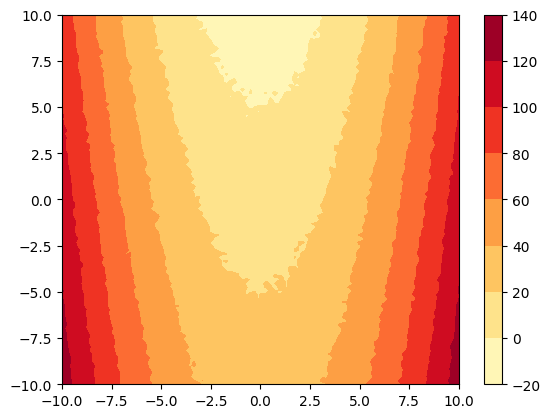

In [5]:
plt.contourf(X[:, 0].reshape(100, 100), X[:, 1].reshape(100, 100), Y.reshape(100, 100), cmap='YlOrRd')
plt.colorbar()

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

## NN model

In [7]:
device = 'cpu'

In [8]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32)

In [9]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=1)
        )
    
    def forward(self, x):
        return self.layers(x)


In [10]:
model_nn = SimpleNN().to(device)

In [11]:
from scripts.metrics import NegMeanSquaredError

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model_nn.parameters())
metric = NegMeanSquaredError()

In [12]:
from scripts.train import train_model

history = train_model(
    model=model_nn,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=100,
    device=device
)

Training model for 100 epochs. Early stopping not enabled.
Epoch: 1 => Train loss: 430.624390, Train score: -430.624390, Val loss: 56.689098, Val score: -56.689098
Epoch: 2 => Train loss: 50.216412, Train score: -50.216412, Val loss: 43.471725, Val score: -43.471725
Epoch: 3 => Train loss: 39.480919, Train score: -39.480919, Val loss: 37.415291, Val score: -37.415291
Epoch: 4 => Train loss: 31.606174, Train score: -31.606174, Val loss: 27.894278, Val score: -27.894278
Epoch: 5 => Train loss: 24.860872, Train score: -24.860872, Val loss: 22.415724, Val score: -22.415724
Epoch: 6 => Train loss: 19.322130, Train score: -19.322130, Val loss: 18.451925, Val score: -18.451925
Epoch: 7 => Train loss: 14.130854, Train score: -14.130854, Val loss: 13.290078, Val score: -13.290078
Epoch: 8 => Train loss: 9.014634, Train score: -9.014634, Val loss: 5.956601, Val score: -5.956601
Epoch: 9 => Train loss: 4.169325, Train score: -4.169325, Val loss: 3.014826, Val score: -3.014826
Epoch: 10 => Train l

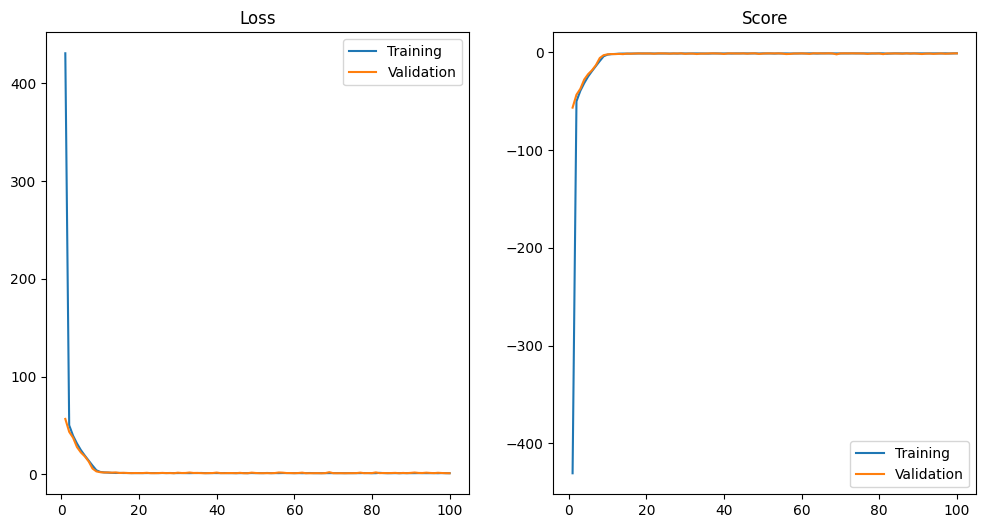

In [13]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [14]:
from scripts.test import predict

preds_train, preds_val = predict(model_nn, X_train, device), predict(model_nn, X_val, device)
score_train, score_val = metric(preds_train, Y_train), metric(preds_val, Y_val)
score_train, score_val

(tensor(-1.0517), tensor(-1.1614))

In [15]:
preds_nn = predict(model_nn, X, device).squeeze()
preds_nn.shape

torch.Size([10000])

## NTK

In [16]:
def get_grads(u, model):
    return torch.cat([torch.reshape(grads, (-1,)) for grads in list(torch.autograd.grad(model(u), model.parameters()))]).reshape(1, -1)
     
def compute_ntk(U, V, model):
    phi_u = torch.cat([get_grads(u, model) for u in U])
    phi_v = torch.cat([get_grads(v, model) for v in V])
    return torch.matmul(phi_u, phi_v.T)

In [17]:
class NTK():
    def __init__(self, model) -> None:
        self.model = model
    
    def get_ntk(self, U, V):
        return compute_ntk(U, V, self.model)

In [18]:
# u = torch.tensor([-6., 4.])
# model_nn(u)

In [19]:
# dummy = torch.cat([torch.reshape(grads, (-1,)) for grads in list(torch.autograd.grad(model_nn(u), model_nn.parameters()))])
# dummy.reshape(1, -1)

In [20]:
# torch.autograd.grad(outputs=model_nn(u), inputs=model_nn.parameters())

## SVM

In [21]:
from sklearn.metrics import mean_squared_error

In [22]:
from sklearn.svm import SVR

### T = 0

In [23]:
ntk_init = NTK(SimpleNN().to(device))

In [24]:
model_km_init = SVR(kernel=ntk_init.get_ntk)

In [25]:
model_km_init.fit(X_train, Y_train.squeeze())

SVR(kernel=<bound method NTK.get_ntk of <__main__.NTK object at 0x7f5ae476f010>>)

In [26]:
preds_train, preds_val = model_km_init.predict(X_train), model_km_init.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(4.195614279520948, 4.552303088301519)

In [27]:
preds_init = model_km_init.predict(X)
preds_init.shape

(10000,)

### T = inf

In [28]:
ntk_inf = NTK(model=model_nn)

In [29]:
model_km_inf = SVR(kernel=ntk_inf.get_ntk)

In [30]:
model_km_inf.fit(X_train, Y_train.squeeze())

SVR(kernel=<bound method NTK.get_ntk of <__main__.NTK object at 0x7f5ae474e110>>)

In [31]:
preds_train, preds_val = model_km_inf.predict(X_train), model_km_inf.predict(X_val)
score_train, score_val = mean_squared_error(Y_train, preds_train), mean_squared_error(Y_val, preds_val)
score_train, score_val

(0.9403403935555293, 1.1476796888955787)

In [32]:
preds_inf = model_km_inf.predict(X)
preds_inf.shape

(10000,)

## Plots

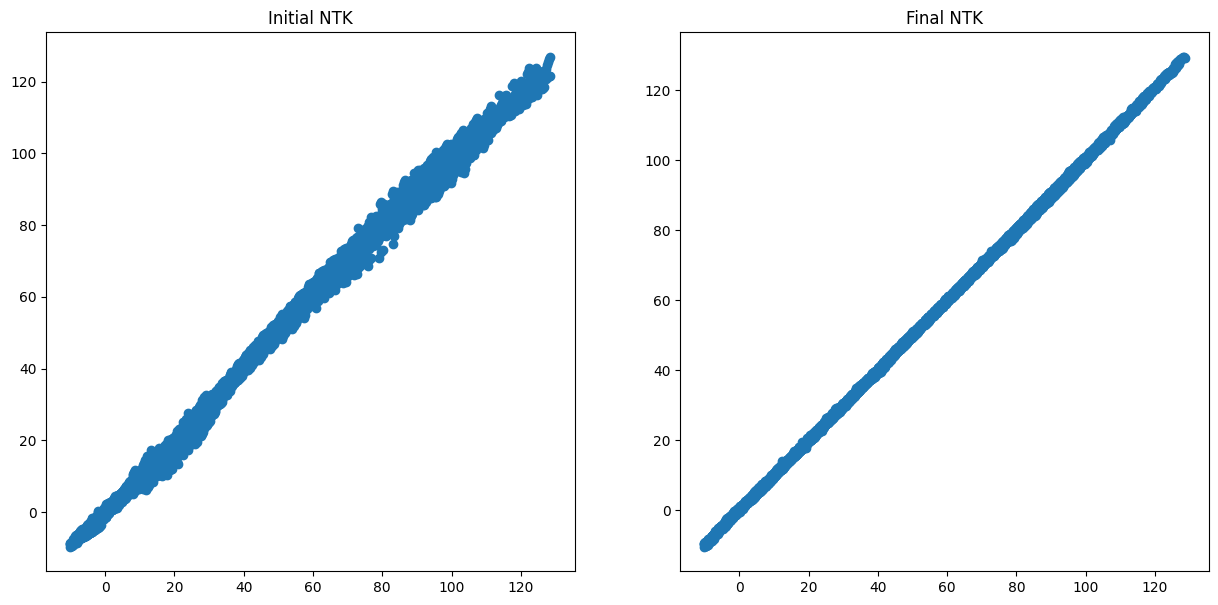

In [34]:
plt.figure(figsize=(15, 7))

plt.subplot(121)
plt.scatter(preds_nn, preds_init)
plt.title('Initial NTK')

plt.subplot(122)
plt.scatter(preds_nn, preds_inf)
plt.title('Final NTK')

plt.show()